# Part 1 - retrieving data

In this part we will retrieve the data and create a document corpus. Each file will be loaded as a separate document from the documentation archive. The content is categorized in subfolders. 

Documentation is written in [AsciiDoc](http://asciidoc.org/). Each product is documented in a separate folder. The folder has several versions of the documentation and each version has the following structure:
  - _attachments folder
  - _images folder
  - content .adoc files

Only .adoc files will get retrieved while images, attachments and other configuration files will be ommitted.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import numpy as np

In [5]:
def create_dataframe(dir_path):
    corpus = []
    for root, dirs, files in os.walk(dir_path):
        for file_name in files:
            file_n = file_name.split('.')[0]
            if '.' not in file_name:
                continue
            file_ext = file_name.split('.')[1]
            if file_ext != 'adoc' or file_n == '_toc':
                continue
            full_file_path = os.path.join(root, file_name)
            with open(full_file_path) as file:
                content = file.read()
                corpus.append({"file":full_file_path, "text":content})
    return pd.DataFrame(corpus)
                

In [6]:
corpus_df = create_dataframe(os.path.join(os.getcwd(), 'mulesoft-docs-master'))

In [7]:
corpus_df.head()

,file,text
0,/home/kliton/Documents/Springboard/Capstone2/m...,= Glossary\n:keywords: glossary\n\nThe followi...
1,/home/kliton/Documents/Springboard/Capstone2/m...,"= MuleSoft Documentation\n:keywords: platform,..."
2,/home/kliton/Documents/Springboard/Capstone2/m...,= To Set the API URL\n\nOn the API version det...
3,/home/kliton/Documents/Springboard/Capstone2/m...,"= To Disable, Edit, or Remove a Policy\n\n. In..."
4,/home/kliton/Documents/Springboard/Capstone2/m...,"= IP Blacklist\n:keywords: IP, blacklist, vali..."


The number of text files in the corpus is:

In [8]:
len(corpus_df)

1301

Let's have a look at the number of documents per product. This will correspond to the number of files in each folder.

In [377]:
docs_per_product = corpus_df.file.apply(lambda x: x.split("/")[7] if len(x.split("/")) > 8 else "").value_counts()

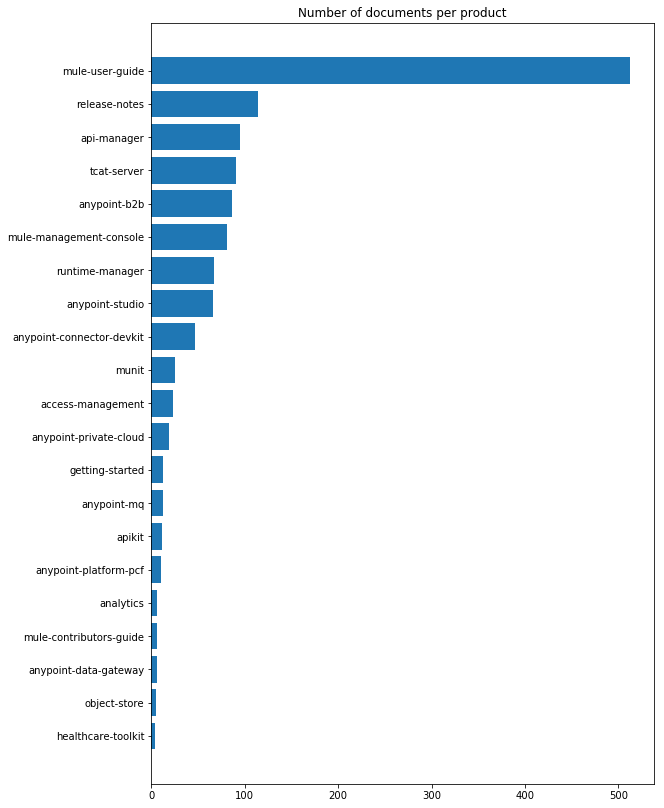

In [416]:
fig = plt.figure( figsize=(9,14))
axes = fig.add_subplot(111, title = "Number of documents per product")
plt.barh(np.arange(len(docs_per_product.index) -1), docs_per_product.values[-2::-1], 
         tick_label = docs_per_product.index[-2::-1]);

Mule Runtime is the product with the most files. This is the core product of the company. While Release Notes takes the second place on the number of documents per product, it should not be included in the corpus. Release notes document each new version of the product including improvements, known issues, etc. For the purpose of this project the presence of Release notes is not required and it can bias some of the results. 

In [446]:
corpus_df = corpus_df[corpus_df.file.apply(lambda x: x.split("/")[7] if len(x.split("/")) > 8 else "") != 'release-notes']

Now, let's have a look at the remaining number of documents:

In [448]:
print("Number of documents: ", len(corpus_df))

Number of documents:  1187


The text should be processed. We should remove the following text elements:
    - asciidoc format tags
    - remove web links
    - remove code snippets (mostly xml configurations, probably some java code)
    - remove spaces and new lines (\n)
    - treat all the tokens that include period marks (.) in a special way by replacing those to underscores i.e. org.mulesoft.module to org_mulesoft_module, 3.8.1 to 3_8_1, etc. Those are meaningful tokens.
    
A document looks like the following:

In [208]:
corpus_df.text.iloc[301]

'= SAP Connector Troubleshooting\n:keywords: sap, connector, troubleshooting\n:imagesdir: ./_images\n\nThis page contains common troubleshooting suggestions for the link:/mule-user-guide/v/3.8/mulesoft-enterprise-java-connector-for-sap-reference[SAP Connector].\n\n\n[[checking-log-files]]\n== Checking Log Files\n\nMule stores log files (on a per application basis) in the `$MULE_HOME\\logs` directory:\n\n* `mule.log` - default Mule log file.\n* `mule-app-YOUR_APP_NAME.log` - per application log file.\n\n[[enabling-jco-trace]]\n== Enabling JCo Trace\n\nJCo Trace can be enabled from outside Mule and accepts the following Java startup environment properties:\n\n* `-Djco.trace_level=N` (where 0 \\<= N \\<= 10, with 10 = most detailed trace)\n* `-Djco.trace_path=<PATH>` (optional)\n\nTo enable traces at the connector level, perform the following steps:\n\n. Set the attribute `jcoTrace` to `true` or provide the extended JCo property `jco.client.trace` or `jco.server.trace` with value `1`.\n. 

To handle the preprocessing task we create this procedure:

In [449]:
def processText(str_input):
    
    # regex to remove links
    link_comp = re.compile(r"link:.*?\[(\w*)\]*?")
    
    # regex to remove images
    image_comp =re.compile(r"image:.*?\[(\w([\s.-])*)*\]*?")
    
    image_regex = r"image:.*\[((\w(\s\S)*)*)\]"
    
    # regex to remove code
    codeblock_comp= re.compile(r"\n\[(\w[,-.\s]*)+\]\n----.*?----", flags=re.S)
    
    # regex to remove other asciidoc tags
    asciid_tags = re.compile(r"(\[\[\S*?\]\])|(\[\S*?\])", flags=re.S)
    
    str_without_links = "".join(link_comp.split(str_input))
    str_without_images = image_comp.subn(" ", str_without_links)[0]
    str_without_code = codeblock_comp.subn(" ", str_without_images)[0]
    str_without_tags = asciid_tags.subn(" ", str_without_code)[0]
    str_linkexc = re.sub(r"(([a-zA-z0-9\-]+)[\.])+([a-zA-z0-9\-]+)", 
                         lambda x: x.group().replace(".", "_"),
                        str_without_tags)
    
    # regex to remove all the other punctuations
    punct_comp = re.compile(r"[\:\+\|=\[\]®`<>\/\(\)\{\}\*\n\t\$\"\\]")
    str_linkexc = punct_comp.subn(" ", str_linkexc)[0]
    
    return str_linkexc.lower()
    

Add another column in the corpus and apply the text processing procedure to clean the text:

In [342]:
corpus_df.loc[:, "stripped_txt"] = corpus_df.text.apply(processText)

The processed text looks like this:

In [450]:
processText(corpus_df.text.iloc[301])

"  sap connector troubleshooting  keywords  sap, connector, troubleshooting  imagesdir  . _images  this page contains common troubleshooting suggestions for the sap connector .        checking log files  mule stores log files  on a per application basis  in the   mule_home logs  directory      mule_log  - default mule log file.    mule-app-your_app_name_log  - per application log file.       enabling jco trace  jco trace can be enabled from outside mule and accepts the following java startup environment properties      -djco_trace_level n   where 0     n     10, with 10   most detailed trace     -djco_trace_path  path    optional   to enable traces at the connector level, perform the following steps   . set the attribute  jcotrace  to  true  or provide the extended jco property  jco_client_trace  or  jco_server_trace  with value  1 . . provide a value for  -djco_trace_level n  at mule startup.  jco offers trace levels from 0 to 10 . the amount of traced data increases with the chosen t

Now, we can proceed with some more text analysis. 

In [343]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Create a bag-of-words representation by using CountVectorizer. To explore we define a limit of 1000 features

In [361]:
word_vectorizer = CountVectorizer( stop_words='english', min_df=2, max_df=0.95, max_features=1000)

In [469]:
bow_1gram = word_vectorizer.fit_transform(corpus_df.stripped_txt)

The bag of words is a matrix consisting of document index in the rows and feature (word) index in the columns. The shape of the matrix is:

In [470]:
bow_1gram.shape

(1187, 1000)

As expected, the row count matches the number of documents and the columns count matches the number of features.

Let's have a quick look at the vocabulary:

In [473]:
word_vectorizer.get_feature_names()

['10',
 '1_0',
 '1_1',
 '20',
 '200',
 '2_0',
 '3_7_0',
 '500',
 '8081',
 'ability',
 'able',
 'abstract',
 'accept',
 'accepts',
 'access',
 'accessing',
 'according',
 'account',
 'action',
 'actions',
 'active',
 'actual',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'addresses',
 'adds',
 'admin',
 'administration',
 'administrator',
 'advanced',
 'agent',
 'ajax',
 'alert',
 'alerts',
 'allow',
 'allowed',
 'allows',
 'amazon',
 'analytics',
 'annotation',
 'annotations',
 'anypoint',
 'apache',
 'api',
 'apikit',
 'apis',
 'apm',
 'app',
 'appear',
 'appears',
 'application',
 'applications',
 'applied',
 'applies',
 'apply',
 'appropriate',
 'apps',
 'architecture',
 'argument',
 'arguments',
 'array',
 'artifact',
 'as2',
 'assert',
 'assign',
 'assigned',
 'associated',
 'assumes',
 'async',
 'asynchronous',
 'attempts',
 'attribute',
 'attributes',
 'authentication',
 'authorization',
 'auto',
 'automatically',
 'availability',
 'available',
 'avoid',

There are a lot of the same words listed both in singular and plural for nouns and also other modifications for verbs (verb tense, gerunds, etc.). It would be best to stem or lemmatize the words.

With the above information we can plot the word frequency proportion in the documents:

In [484]:
x, counts = np.unique((bow_1gram > 0).sum(0).tolist()[0], return_counts=True)

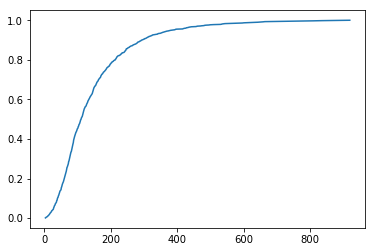

In [478]:
plt.plot(x, counts.cumsum()/counts.sum());

The distribution of word frequencies in the document is displayed above. In the x-axis is the number of documents that a word appears in. On the y-axis is displayed the percentage of words that are part of x or less documents. For this example we considered only 1000 features (words). This test should be conducted on the whole dataset. 

With the information that we have retrieved so far we can visualize the most frequent words in all documents in a word cloud:

In [417]:
from wordcloud import WordCloud

In [440]:
wc = WordCloud().generate_from_frequencies(zip(word_vectorizer.get_feature_names(), bow_1gram.sum(axis=0).tolist()[0]) )

(-0.5, 399.5, 199.5, -0.5)

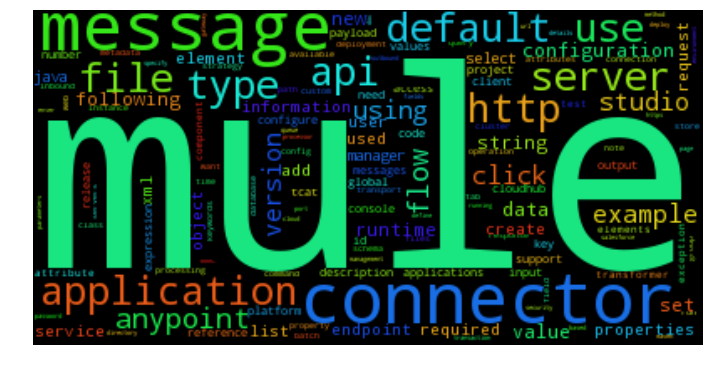

In [455]:
plt.figure(figsize=(12, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# Analyzing text with SpaCy

In [52]:
import spacy
import itertools as it

nlp = spacy.load('en')

In [459]:
%%time

parsed_doc301 = nlp(corpus_df.stripped_txt.iloc[301])

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 125 ms


In [460]:
print(parsed_doc301)

  sap connector troubleshooting  keywords  sap, connector, troubleshooting  imagesdir  . _images  this page contains common troubleshooting suggestions for the sap connector .        checking log files  mule stores log files  on a per application basis  in the   mule_home logs  directory      mule_log  - default mule log file.    mule-app-your_app_name_log  - per application log file.       enabling jco trace  jco trace can be enabled from outside mule and accepts the following java startup environment properties      -djco_trace_level n   where 0     n     10, with 10   most detailed trace     -djco_trace_path  path    optional   to enable traces at the connector level, perform the following steps   . set the attribute  jcotrace  to  true  or provide the extended jco property  jco_client_trace  or  jco_server_trace  with value  1 . . provide a value for  -djco_trace_level n  at mule startup.  jco offers trace levels from 0 to 10 . the amount of traced data increases with the chosen tr

In [465]:
token_text = [token.orth_ for token in parsed_doc301]
token_lemma = [token.lemma_ for token in parsed_doc301]
token_shape = [token.shape_ for token in parsed_doc301]
parsed_doc301.sents
#pd.DataFrame(zip(token_text, token_lemma, token_shape),
#             columns=['token_txt', 'token_lemma', 'token_shape'])

In [468]:
#[print(x) for x in parsed_doc301]
parsed_doc301.text_with_ws

"  sap connector troubleshooting  keywords  sap, connector, troubleshooting  imagesdir  . _images  this page contains common troubleshooting suggestions for the sap connector .        checking log files  mule stores log files  on a per application basis  in the   mule_home logs  directory      mule_log  - default mule log file.    mule-app-your_app_name_log  - per application log file.       enabling jco trace  jco trace can be enabled from outside mule and accepts the following java startup environment properties      -djco_trace_level n   where 0     n     10, with 10   most detailed trace     -djco_trace_path  path    optional   to enable traces at the connector level, perform the following steps   . set the attribute  jcotrace  to  true  or provide the extended jco property  jco_client_trace  or  jco_server_trace  with value  1 . . provide a value for  -djco_trace_level n  at mule startup.  jco offers trace levels from 0 to 10 . the amount of traced data increases with the chosen t

In [462]:
count = 10
for txt, lemma, shape in zip(token_text, token_lemma, token_shape):
    print(txt, lemma, shape)

        
sap sap xxx
connector connector xxxx
troubleshooting troubleshooting xxxx
     
keywords keyword xxxx
     
sap sap xxx
, , ,
connector connector xxxx
, , ,
troubleshooting troubleshooting xxxx
     
imagesdir imagesdir xxxx
     
. . .
_ _ _
images image xxxx
     
this this xxxx
page page xxxx
contains contain xxxx
common common xxxx
troubleshooting troubleshooting xxxx
suggestions suggestion xxxx
for for xxx
the the xxx
sap sap xxx
connector connector xxxx
. . .
                    
checking check xxxx
log log xxx
files file xxxx
     
mule mule xxxx
stores store xxxx
log log xxx
files file xxxx
     
on on xx
a a x
per per xxx
application application xxxx
basis basis xxxx
     
in in xx
the the xxx
        
mule_home mule_home xxxx_xxxx
logs log xxxx
     
directory directory xxxx
                
mule_log mule_log xxxx_xxx
     
- - -
default default xxxx
mule mule xxxx
log log xxx
file file xxxx
. . .
           
mule mule xxxx
- - -
app app xxx
- - -
your_app_name_log y